In [1]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from sklearn.preprocessing import MinMaxScaler
from copy import deepcopy as dc
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import yfinance as yf
import datetime



In [2]:
msft = yf.Ticker("DELL")
print(msft)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


msft.info

df = msft.history(period="5y")
df

df = df[['Close']]
df


yfinance.Ticker object <DELL>


,Close
Date,
2019-07-12 00:00:00-04:00,25.621464
2019-07-15 00:00:00-04:00,26.307499
2019-07-16 00:00:00-04:00,26.683861
2019-07-17 00:00:00-04:00,26.917303
2019-07-18 00:00:00-04:00,27.341311
...,...
2024-07-08 00:00:00-04:00,145.970001
2024-07-09 00:00:00-04:00,145.740005
2024-07-10 00:00:00-04:00,145.770004


In [3]:
def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)

    for i in range(1, n_steps+1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)

    df.dropna(inplace=True)

    return df


lookback = 7
shifted_df = prepare_dataframe_for_lstm(df, lookback)
shifted_df

shifted_df_np = shifted_df.to_numpy()
shifted_df_np


array([[ 26.42183685,  26.87919044,  27.06022835, ...,  26.68386078,
         26.30749893,  25.62146378],
       [ 26.78390884,  26.42183685,  26.87919044, ...,  26.91730309,
         26.68386078,  26.30749893],
       [ 26.23603249,  26.78390884,  26.42183685, ...,  27.3413105 ,
         26.91730309,  26.68386078],
       ...,
       [145.77000427, 145.74000549, 145.97000122, ..., 143.47000122,
        142.82000732, 137.91000366],
       [140.72000122, 145.77000427, 145.74000549, ..., 142.66999817,
        143.47000122, 142.82000732],
       [140.21000671, 140.72000122, 145.77000427, ..., 138.96000671,
        142.66999817, 143.47000122]])

In [4]:
scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_np = scaler.fit_transform(shifted_df_np)

shifted_df_np

X = shifted_df_np[:, 1:]
y = shifted_df_np[:, 0]

X.shape, y.shape
print(X)

X = dc(np.flip(X, axis=1))
X
split_index = int(len(X) * .95)
split_index

X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape



[[-0.84134556 -0.83915721 -0.83575954 ... -0.84370666 -0.84825605
  -0.85654872]
 [-0.84687396 -0.84134556 -0.83915721 ... -0.84088486 -0.84370666
  -0.84825605]
 [-0.8424973  -0.84687396 -0.84134556 ... -0.83575954 -0.84088486
  -0.84370666]
 ...
 [ 0.59542107  0.59820122  0.51346575 ...  0.5679817   0.5601247
   0.50077352]
 [ 0.59578369  0.59542107  0.59820122 ...  0.55831142  0.5679817
   0.5601247 ]
 [ 0.53474023  0.59578369  0.59542107 ...  0.51346575  0.55831142
   0.5679817 ]]


(torch.Size([1189, 7, 1]),
 torch.Size([63, 7, 1]),
 torch.Size([1189, 1]),
 torch.Size([63, 1]))

In [5]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]


train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)
train_dataset


batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



In [6]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break


class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,
                            batch_first=True)

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size,
                         self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size,
                         self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out


model = LSTM(1, 16, 2)
model.to(device)
model



torch.Size([16, 7, 1]) torch.Size([16, 1])


LSTM(
  (lstm): LSTM(1, 16, num_layers=2, batch_first=True)
  (fc): Linear(in_features=16, out_features=1, bias=True)
)

In [7]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()


def validate_one_epoch():
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)

    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()


learning_rate = 0.003
num_epochs = 30
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()


Epoch: 1

Val Loss: 0.495
***************************************************

Epoch: 2

Val Loss: 0.126
***************************************************

Epoch: 3

Val Loss: 0.044
***************************************************

Epoch: 4

Val Loss: 0.014
***************************************************

Epoch: 5

Val Loss: 0.020
***************************************************

Epoch: 6

Val Loss: 0.024
***************************************************

Epoch: 7

Val Loss: 0.014
***************************************************

Epoch: 8

Val Loss: 0.015
***************************************************

Epoch: 9

Val Loss: 0.012
***************************************************

Epoch: 10

Val Loss: 0.015
***************************************************

Epoch: 11

Val Loss: 0.011
***************************************************

Epoch: 12

Val Loss: 0.016
***************************************************

Epoch: 13

Val Loss: 0.011
**********************

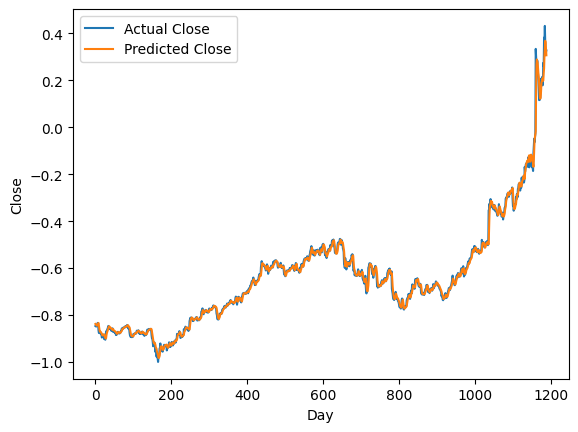

torch.Size([1189, 1])
(1189, 1)
(1189,)


In [8]:
plt.plot(y_train, label='Actual Close')

plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

print(y_train.shape)
print(predicted.shape)
train_predictions = predicted.flatten()
print(train_predictions.shape)


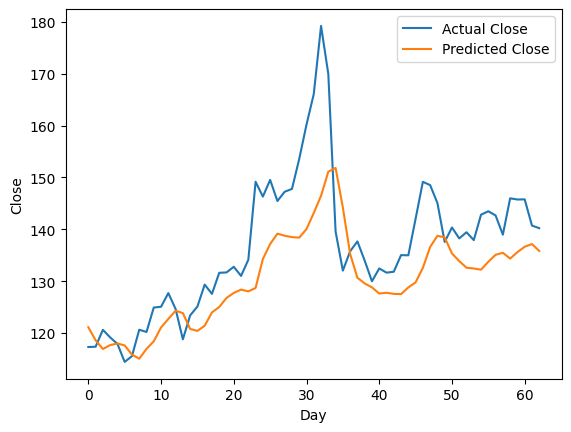

array([121.11046401, 118.60592942, 116.91674222, 117.66244208,
       117.97433595, 117.60444892, 115.83105796, 115.04695199,
       116.92878612, 118.40560866, 121.07331899, 122.7136267 ,
       124.30163158, 123.83743476, 120.78196756, 120.40567026,
       121.40577502, 123.97597537, 125.01313145, 126.76306454,
       127.7338596 , 128.37202112, 128.02343589, 128.6982444 ,
       134.27556377, 137.15872308, 139.15749275, 138.75686604,
       138.48818228, 138.39301944, 140.039624  , 143.14935163,
       146.45909922, 151.10808907, 151.8313937 , 144.1819515 ,
       135.24689631, 130.65247753, 129.55988745, 128.8046104 ,
       127.60654189, 127.76212393, 127.54525483, 127.5035536 ,
       128.79167153, 129.76464115, 132.56767216, 136.58896894,
       138.74181178, 138.43463192, 135.3425621 , 133.8684331 ,
       132.5929927 , 132.4414294 , 132.21497449, 133.73231854,
       135.07887342, 135.46967271, 134.34266444, 135.59474682,
       136.63159719, 137.15078914, 135.81993447])

In [9]:
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train


test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


test_predictions



Test Results:
                        Date      Actual   Predicted
0  2024-04-12 00:00:00-04:00  117.303810  121.110464
1  2024-04-15 00:00:00-04:00  117.353608  118.605929
2  2024-04-16 00:00:00-04:00  120.610947  116.916742
3  2024-04-17 00:00:00-04:00  119.156601  117.662442
4  2024-04-18 00:00:00-04:00  117.911446  117.974336
..                       ...         ...         ...
58 2024-07-08 00:00:00-04:00  145.970001  134.342664
59 2024-07-09 00:00:00-04:00  145.740006  135.594747
60 2024-07-10 00:00:00-04:00  145.770006  136.631597
61 2024-07-11 00:00:00-04:00  140.720000  137.150789
62 2024-07-12 00:00:00-04:00  140.210009  135.819934

[63 rows x 3 columns]
                        Date      Actual   Predicted   Signal
0  2024-04-12 00:00:00-04:00  117.303810  121.110464      Buy
1  2024-04-15 00:00:00-04:00  117.353608  118.605929      Buy
2  2024-04-16 00:00:00-04:00  120.610947  116.916742     Sell
3  2024-04-17 00:00:00-04:00  119.156601  117.662442     Sell
4  2024-04-18 00:

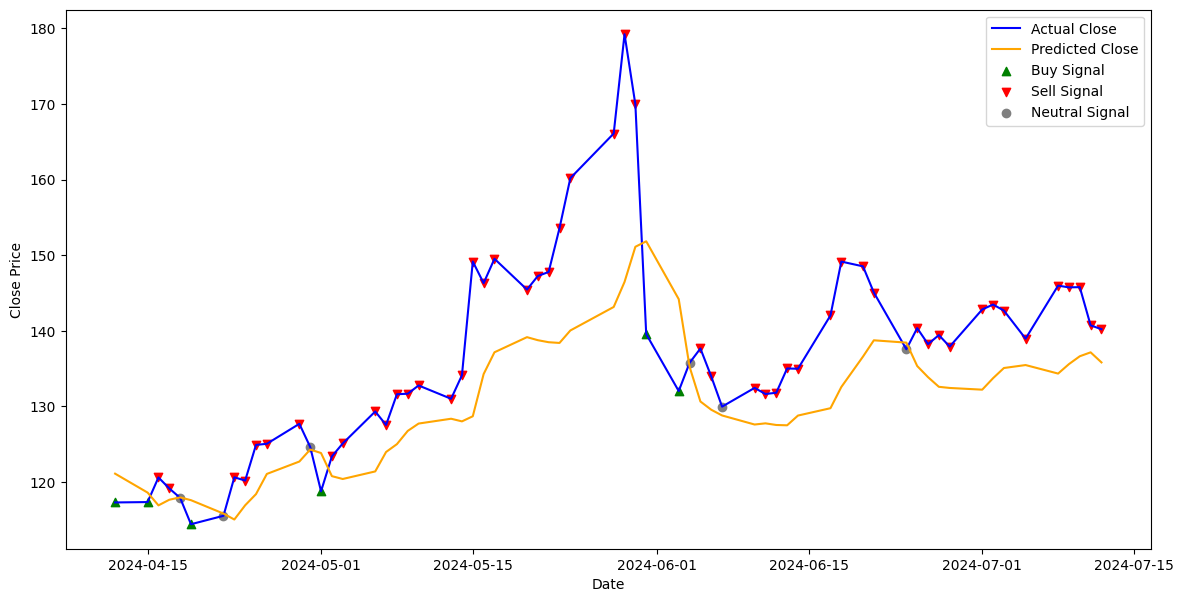

In [10]:
test_dates = df.index[-len(new_y_test):]

# Create dataframe with dates, actual and predicted values
test_results_df = pd.DataFrame({
    'Date': test_dates,
    'Actual': new_y_test,
    'Predicted': test_predictions
})
print("Test Results:")
print(test_results_df)


def generate_trading_signals(test_results_df, neutral_threshold=0.01):
    test_results_df['Signal'] = 'Neutral'

    test_results_df.loc[test_results_df['Predicted'] >
                        test_results_df['Actual'] * (1 + neutral_threshold), 'Signal'] = 'Buy'
    test_results_df.loc[test_results_df['Predicted'] <
                        test_results_df['Actual'] * (1 - neutral_threshold), 'Signal'] = 'Sell'

    return test_results_df


test_results_df_with_signals = generate_trading_signals(test_results_df)
print(test_results_df_with_signals)

# Visualization of trading signals
plt.figure(figsize=(14, 7))
plt.plot(test_results_df['Date'], test_results_df['Actual'],
         label='Actual Close', color='b')
plt.plot(test_results_df['Date'], test_results_df['Predicted'],
         label='Predicted Close', color='orange')
buy_signals = test_results_df_with_signals[test_results_df_with_signals['Signal'] == 'Buy']
sell_signals = test_results_df_with_signals[test_results_df_with_signals['Signal'] == 'Sell']
neutral_signals = test_results_df_with_signals[test_results_df_with_signals['Signal'] == 'Neutral']
plt.scatter(buy_signals['Date'], buy_signals['Actual'],
            label='Buy Signal', marker='^', color='g')
plt.scatter(sell_signals['Date'], sell_signals['Actual'],
            label='Sell Signal', marker='v', color='r')
plt.scatter(neutral_signals['Date'], neutral_signals['Actual'],
            label='Neutral Signal', marker='o', color='gray')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()
